# Booking Hotels Scrapper

GROUP 8:  Viktoriia Yuzkiv, Sebastien Boxho, Arianna Michelangelo

This notebook includes the pipeline to scrape Booking.com listings data and saves the data into a csv file.


**1. Identify a (future) event that makes a lot of people come to Barcelona.**

After careful consideration we decided on **The Mobile World Congress (MWC)  26 - 29 February 2024**

The Mobile World Congress (MWC) is one of the most significant events in the mobile technology industry, attracting professionals from across the globe to showcase and discuss the latest innovations in mobile and wireless technology. Held annually in Barcelona, it's organized by the GSMA (Global System for Mobile Communications Association), which represents the interests of mobile operators worldwide. We decided to work with this event for the following reasons: 

- Large-scale Attendance: MWC attracts over 100,000 attendees from around the world, significantly increasing demand for accommodation. This surge can lead to short-term price increases, making it a significant factor for a DiD analysis.
- Treatment vs. Control Groups: Barcelona, as the host city, can serve as the treatment group, while other cities we chose do not host similar events during the same time frame can serve as control groups. This setup allows for assessing the causal impact of MWC on hotel prices by comparing changes in prices between the two groups.
- International Exposure: The global nature of MWC means that the demand increase is not only local but also international, potentially affecting a broader range of accommodations (hotels, apartments, etc.) and thus providing a comprehensive view of its impact on prices.

**2. Think of the time periods to scrape and what second city to scrape for these same
timer periods.**

Dates:
- MWC Barcelona: 26 - 29 February 2024 (selected period: 23 Feb - 3 Mar)
- The control period: March 8 - 17th

We opted to conduct our data scraping from February 23rd to March 3rd to include the weekends, anticipating that attendees of the conference might extend their stay in the city during these days. For the control period, we selected March, considering it a low season comparable to February. This choice is based on the similarity in weather conditions—both months are cold, outside the beach season, and typically experience a decrease in tourist activity, making March an appropriate counterpart for analyzing the impact of the conference.

Control cities:
- Marseille
- Valencia
- Porto

These cities were chosen based on their resemblance to Barcelona in several key aspects. Firstly, they share similar climatic conditions, ensuring that weather patterns do not unduly influence our comparisons. Secondly, they boast attractions of architectural significance and are well-known as beach destinations, mirroring Barcelona's dual appeal in these areas. Additionally, the economies of France and Portugal are comparable to that of Spain in terms of tourism, given their positions within similar economic contexts in Europe. Importantly, during the period of our study, none of these cities hosted events that could significantly disrupt hotel pricing, ensuring a stable baseline for comparison. This careful selection criteria aim to provide a robust and reliable control group, reflecting the influence of the Mobile World Congress on Barcelona's accommodation sector without confounding factors. 



**3. Design a careful scraping pipeline that follows the advises seen in class and TAs.**

### Paths

In [1]:
# This cell is for the path configuration (relative to the notebook)

# Path to your geckodriver file - please change to your path before running the code
geko_path = 'C:/Users/School/Downloads/geckodriver-v0.34.0-win64/geckodriver.exe' 

# Please change to your profile path (if you have one Firefox profile)
profile_path = '/Users/viktoriia/Library/Application Support/Firefox/Profiles/k7kr4dw0.Viktoriia' 

# Booking link
link = 'https://www.booking.com/index.en-gb.html'

### Import libraries

In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import NoSuchElementException

import os
import re
import time
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import concurrent.futures
import statsmodels.api as sm
import statsmodels.api as smf
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor

import src.booking_scrapper as bs
import src.description_analysis as da

## Part 1: Hotel Scrapper

This section of the notebook uses the booking_scrapper.py file to scrap the intended data from Booking.com in the given city and time period.

The next cell contains the parameters used to scrapp the data, the parameters used for both datasets generated were:
- cities = ['Barcelona','Marseille','Valencia','Porto']
- Dataset 1: start_date = '2024-02-23' end_date = '2024-03-03'
- Dataset 2: start_date = '2024-03-08' end_date = '2024-03-17'
- interval = 1
- p_limit = 40
You can adjust the parameters as you may like to scrape, caution that the running time is hughly affected by the interval value and p_limit.

In [3]:
# Select Cities: List of cities to search examples: ['Barcelona','Marseille','Valencia','Porto']
cities = ['Barcelona','Marseille']

# Select start and end dates: Format YYYY-MM-DD
start_date = '2024-03-08'
end_date = '2024-03-10'

# Select interval: Number of days for each interval. If None, get prices for the entire range.
interval = 1

# Select page limit: Number of pages to scrape for each city. If None, scrape all pages.
p_limit = 4

Primary data scraping pipeline; if the 'cities' variable comprises multiple values, the pipeline concurrently executes scraping operations for each city, optimizing the overall speed of the process.

In [4]:
def scrape_city(city, start_date, end_date, interval, page_limit):
    """
    Scrapes hotel data for a specific city and date range.

    Parameters:
    - city: City to scrape data for.
    - start_date: Start date in the format 'YYYY-MM-DD'.
    - end_date: End date in the format 'YYYY-MM-DD'.
    - interval: Number of days for each interval. If None, get prices for the entire range.
    - page_limit: Maximum number of pages to scrape.

    Returns:
    - DataFrame containing scraped data with columns: 'City', 'Start_Date', 'End_Date', 'Hotel_Name', 'Price', 'Hotel_Description_Short', 'Rating', 'url'.
    """
    scrapper = bs.Booking_Scrapper()
    result_df = pd.DataFrame(columns=['City', 'Start_Date', 'End_Date', 'Hotel_Name', 'Price', 'Hotel_Description_Short', 'Rating', 'url'])
    browser = scrapper.start_up(link, geko_path)

    s_d = datetime.strptime(start_date, '%Y-%m-%d')
    e_d = datetime.strptime(end_date, '%Y-%m-%d')

    if city == cities[0]:
        scrapper.check_and_click(browser, '.f4552b6561', 'css')
        scrapper.check_and_click(browser, '/html/body/div/div[1]/div/div[1]/div[2]/svg', 'xpath')

    scrapper.select_place(browser, city)

    c_d = s_d

    while c_d < e_d:
        time.sleep(1)
        i_e_d = min(c_d + timedelta(days=interval), e_d) if interval is not None else e_d
        interval_end_date = i_e_d.strftime('%Y-%m-%d')
        current_date = c_d.strftime('%Y-%m-%d')
        print("City: ", city, "Current date: ", current_date, "Interval end date: ", interval_end_date)

        scrapper.select_dates(browser, current_date, interval_end_date)

        if c_d == s_d:
            my_xpath = '/html/body/div[3]/div[2]/div/form/div[1]/div[4]/button/span'
            scrapper.check_and_click(browser, my_xpath, type='xpath')
        else:
            my_xpath = '/html/body/div[4]/div/div[2]/div/div[1]/div/form/div[1]/div[4]/button/span'
            scrapper.check_and_click(browser, my_xpath, type='xpath')

        time.sleep(2)
        scrapper.check_and_click(browser, 'div.cc1b961f14:nth-child(1) > button:nth-child(1)', 'css')

        pages = scrapper.get_number_pages(browser)
        page_stop = min(pages, page_limit) if page_limit is not None else pages

        for p in range(page_stop - 1):
            print("Page: ", p + 1)
            df_temp = pd.DataFrame(scrapper.get_hotels(browser))
            df_temp['City'] = city
            df_temp['Start_Date'] = current_date
            df_temp['End_Date'] = interval_end_date
            result_df = pd.concat([result_df, df_temp], ignore_index=True)
            time.sleep(3)

            if p < page_stop - 1:
                css = 'div.b16a89683f:nth-child(3) > button:nth-child(1)'
                browser.find_element('css selector', css).click()
                time.sleep(2)
            else:
                break

        c_d = i_e_d

    browser.quit()
    return result_df

def scrape_data_parallel(cities, start_date, end_date, interval=None, page_limit=None):
    """
    Scrapes hotel data for the specified cities and date range using parallel execution.

    Parameters:
    - cities: List of cities to scrape data for.
    - start_date: Start date in the format 'YYYY-MM-DD'.
    - end_date: End date in the format 'YYYY-MM-DD'.
    - interval: Number of days for each interval. If None, get prices for the entire range.
    - page_limit: Maximum number of pages to scrape.

    Returns:
    - DataFrame containing scraped data with columns: 'City', 'Start_Date', 'End_Date', 'Hotel_Name', 'Price', 'Hotel_Description_Short', 'Rating', 'url'.
    """
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Create a list of futures, each corresponding to scraping data for one city
        futures = [executor.submit(scrape_city, city, start_date, end_date, interval, page_limit) for city in cities]

        # Wait for all futures to complete
        concurrent.futures.wait(futures)

        # Extract results from completed futures
        results = [future.result() for future in futures]

    # Concatenate results into a single DataFrame
    result_df = pd.concat(results, ignore_index=True)

    return result_df

df = None

**4. Scrape date, room price, hotel name and hotel description.**

## Start Scrapping: (comment to skip this part of the notebook)

In [ ]:
# Scrape data for the specified cities and date range
df = scrape_data_parallel(cities, start_date, end_date, interval=interval, page_limit=p_limit)

In [5]:
if df is not None:
    print("Length of the dataframe: ", len(df))
    print("Unique Hotels in the dataframe: ",len(df['Hotel_Name'].unique()))
    print("Unique Cities in the dataframe: ",len(df['City'].unique()))
    print("Unique Dates in the dataframe: ",len(df['Start_Date'].unique()))

Method to save the scrapped data into a csv file. The file will be named in the format:

[cities]_Start-Date_End-date_Intervall.csv

In [6]:
def save_dataframe_to_csv(df, city, start_date, end_date, interval_days=None):
    # Convert city to a string if it's a list
    if isinstance(city, list):
        city_name = '_'.join(city)
    else:
        city_name = str(city)

    # Build the file name
    file_name_parts = [city_name, start_date, end_date]
    if interval_days is not None:
        file_name_parts.append(f"{interval_days}_days")
    
    file_name = '_'.join(file_name_parts) + '.csv'
    
    # Ensure the 'data' folder exists
    if not os.path.exists('data'):
        os.makedirs('data')

    # Save DataFrame to CSV
    df.to_csv(os.path.join('data', file_name), index=False)

if df is not None:
    save_dataframe_to_csv(df, cities, start_date, end_date, interval)

Within the data folder, you'll find a file named Hotel_Descriptions.csv, housing the previously scraped descriptions of each hotel. This approach guarantees that each description is stored only once, preventing redundant entries in the primary CSV file, given that a particular hotel may appear multiple times.

The download function retrieves descriptions for hotels in the current dataset that are not yet present in the database.

In [7]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36'}

def scrape_description(url):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status() 
        # time.sleep(0.5)
    except requests.exceptions.RequestException as e:
        print(f"Error processing {url}: {e}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')
    description_tag = soup.find('p', class_='a53cbfa6de b3efd73f69')

    if description_tag:
        return description_tag.get_text(strip=True)
    else:
        print(f"Description tag not found on the page: {url}")
        return None

def download_save_description_column(df):
    # Set the number of concurrent threads (adjust this based on the processing power of your computer)
    num_cpus = os.cpu_count()
    
    
    num_threads = max(4, num_cpus - 1)

    df_des = df[['City','Hotel_Name','url']].copy()

    # Drop duplicates
    df_des.drop_duplicates(subset=['Hotel_Name'], inplace=True)

    # If it exist open dataset of descriptions of the city
    if os.path.exists('data/Hotel_Descriptions.csv'):
        df_description = pd.read_csv('data/Hotel_Descriptions.csv')
        print("Hotel_Descriptions.csv length: ", len(df_description))
        df_description.drop_duplicates(subset=['Hotel_Name'], inplace=True)
        df_des = df_des[~df_des['Hotel_Name'].isin(df_description['Hotel_Name'])]
        print("Amount of new descriptions to download: ", len(df_des))
    
    # Create a ThreadPoolExecutor to run operations in parallel
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Use executor.map to apply the scrape_description function to each URL in parallel
        descriptions = []
        for i, description in enumerate(executor.map(scrape_description, df_des['url']), start=1):
            descriptions.append(description)
            # Print every 50 link to check the progess of the scraping
            if i % 50 == 0:
                print(f"Scraped {i} links")

    # Add  descriptions to the 'description' column in the df
    df_des['Hotel_Description_Long'] = descriptions

    # Merge the new descriptions with the existing ones
    if os.path.exists('data/Hotel_Descriptions.csv'):
        df_description = pd.read_csv('data/Hotel_Descriptions.csv')
        df_description = pd.concat([df_description, df_des], ignore_index=True)
    else:
        df_description = df_des

    # Save the descriptions to a CSV file
    print("Lenth of the new dataset: ", len(df_description))
    df_description.to_csv('data/Hotel_Descriptions.csv', index=False)
    
    return df_description

# Example usage:
if df is not None:
    df_description = download_save_description_column(df=df)
    print("New length of the dataset: ", len(df_description))

# Part 2: Difference-in-differences (DiD)

**Treatment period:**
\begin{equation}
Y_{t} = \beta_0 + \beta_1 D_t + \varepsilon_{t}
\end{equation}

$Y_{t}$ is the price for observation $i$ in time period $t$, 
$D_i$ is a dummy variable that takes the value of 1 during the treatment period and 0 otherwise, and 
$\beta_1$ captures the average treatment effect over time

**Treatment city:**
\begin{equation}
Y_{i} = \beta_0 + \beta_2 T_i + \varepsilon_{i}
\end{equation}

$T_i$ is a dummy variable that takes the value of 1 for the treatment city and 0 otherwise, 
$\beta_2$ captures the average difference in prices between the treatment city and the control cities

**Both (final equation):**
\begin{equation}
Y_{it} = \beta_0 + \beta_1 D_t + \beta_2 T_i + \alpha D_t T_i + \varepsilon_{it}
\end{equation}

$T_i$ is the treatment period dummy,
$D_i$ is the treatment city, 
$\alpha$ is the one that captures the DiD estimate, which is the differential change in prices for the treatment group compared to the control group, and
where $T_i = 1$ if individual $i$ is treatment period $t=1$ and $T_i=0$ otherwise


**Why use a second city**

The second city plays the role of a control group which is crucial for DiD analysis because it helps control for time-invariant unobserved factors that may affect prices in both the treatment and control groups. The key assumption in a DiD analysis is the parallel trends assumption, which implies that, in the absence of the treatment, the average outcomes for the treatment and control groups would follow parallel paths over time. Violation of this assumption could lead to biased estimates.


**Why $\alpha$ captures the treatment effect:**

If $\alpha$ is statistically significant and positive, it suggests that the treatment (event) had a differential impact on prices in the treatment city compared to the control cities. This coefficient captures the average treatment effect on prices that cannot be explained by time trends or differences between the treatment and control cities.

### Load and preprocess data:

In [8]:
df1 = pd.read_csv('data\Barcelona_Marseille_Porto_Valencia_2024-02-23_2024-03-03_1_days.csv')
df2 = pd.read_csv('data\Barcelona_Marseille_Porto_Valencia_2024-03-08_2024-03-17_1_days.csv')
df_des = pd.read_csv('data\Hotel_Descriptions.csv')

# Merge dataframes with descriptions based on 'Hotel_Name' and 'City'
df1 = df1.merge(df_des[['City', 'Hotel_Name', 'Hotel_Description_Long']], on=['City', 'Hotel_Name'], how='left')
df2 = df2.merge(df_des[['City', 'Hotel_Name', 'Hotel_Description_Long']], on=['City', 'Hotel_Name'], how='left')

# For the regression analysis make sure to keep the same hotels in both datasets
# Step 1: Identify common hotels across all days
common_hotels = set(df1['Hotel_Name']).intersection(set(df2['Hotel_Name']))
print("Common hotels: ", len(common_hotels))
# Step 2: Filter original dataframes based on common hotels
df1_common = df1[df1['Hotel_Name'].isin(common_hotels)]
df2_common = df2[df2['Hotel_Name'].isin(common_hotels)]

# Handle ¨Price¨ column
df1_common['Price'] = pd.to_numeric(df1_common['Price'].replace('[^\d]', '', regex=True)).iloc[:]
df2_common['Price'] = pd.to_numeric(df2_common['Price'].replace('[^\d]', '', regex=True)).iloc[:]

# Replace Price outliers with the median
def replace_outliers(df, column, threshold=1.5):
    # Calculate the median and the interquartile range
    median = df[column].median()
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    # Replace outliers
    df[column] = np.where(
        (df[column] < df[column].quantile(0.25) - threshold * iqr) | (df[column] > df[column].quantile(0.75) + threshold * iqr),
        median,
        df[column]
    )
    return df

df1_common = replace_outliers(df1_common, 'Price')
df2_common = replace_outliers(df2_common, 'Price')

Common hotels:  2834


C:\Users\School\AppData\Local\Temp\ipykernel_14500\2879551115.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_common['Price'] = pd.to_numeric(df1_common['Price'].replace('[^\d]', '', regex=True)).iloc[:]
C:\Users\School\AppData\Local\Temp\ipykernel_14500\2879551115.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_common['Price'] = pd.to_numeric(df2_common['Price'].replace('[^\d]', '', regex=True)).iloc[:]
C:\Users\School\AppData\Local\Temp\ipykernel_14500\2879551115.py:28: SettingWithCopyWa

In [9]:
#Creation of the dummy variables for the regression
# D is treatment period
# T is treatment city

# Set control city
city_control = 'Valencia'

# Set a dummy variable for the treatment period
df1_common['D'] = 1
df2_common['D'] = 0

# Set a dummy variable for the treatment city
df1_common['T'] = np.where(df1_common['City'] == 'Barcelona', 1, 0)
df2_common['T'] = np.where(df2_common['City'] == 'Barcelona', 1, 0)

C:\Users\School\AppData\Local\Temp\ipykernel_14500\1903982185.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_common['D'] = 1
C:\Users\School\AppData\Local\Temp\ipykernel_14500\1903982185.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_common['D'] = 0
C:\Users\School\AppData\Local\Temp\ipykernel_14500\1903982185.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [10]:
df1_common.head()

,City,Start_Date,End_Date,Hotel_Name,Price,Hotel_Description_Short,Rating,url,Hotel_Description_Long,D,T
0,Barcelona,2024-02-23,2024-02-24,Room Mate Gerard,224.0,NaN,8.8,https://www.booking.com/hotel/es/room-mate-ger...,Room Mate Gerard in Barcelona provides accommo...,1,1
1,Barcelona,2024-02-23,2024-02-24,Sonder Los Arcos,271.0,NaN,8.4,https://www.booking.com/hotel/es/sonder-los-ar...,Sonder Los Arcos features accommodation with f...,1,1
2,Barcelona,2024-02-23,2024-02-24,Citadines Ramblas Barcelona,116.0,NaN,8.5,https://www.booking.com/hotel/es/citadines.en-...,Centrally located on Barcelona’s famous Las Ra...,1,1
3,Barcelona,2024-02-23,2024-02-24,Hotel Derby,101.0,NaN,8.3,https://www.booking.com/hotel/es/derby.en-gb.h...,Situated 300 metres from L’Illa Diagonal Shopp...,1,1
4,Barcelona,2024-02-23,2024-02-24,Hotel Concordia Barcelona,105.0,NaN,8.1,https://www.booking.com/hotel/es/concordia.en-...,Hotel Concordia Barcelona is situated 800 metr...,1,1


In [11]:
df1_common.describe()

,Price,Rating,D,T
count,18321.000000,16810.000000,18321.0,18321.000000
mean,131.741062,8.171142,1.0,0.244201
std,64.431061,1.105837,0.0,0.429624
min,25.000000,1.000000,1.0,0.000000
25%,84.000000,7.800000,1.0,0.000000
50%,123.000000,8.400000,1.0,0.000000
75%,164.000000,8.900000,1.0,0.000000
max,344.000000,10.000000,1.0,1.000000


In [12]:
df1.shape

(20663, 9)

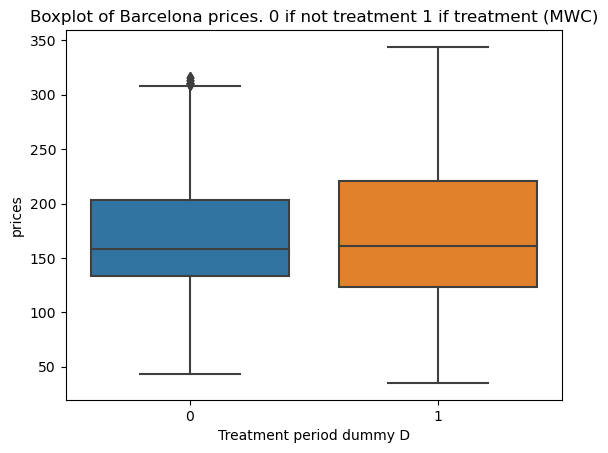

In [13]:
# Concatenate both dataset only for the city of Barcelona
barcelona_df = pd.concat([df1_common[df1_common['City']=='Barcelona'], df2_common[df2_common['City']=='Barcelona']], ignore_index=True)

# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_df , x='D', y='Price')
plt.title('Boxplot of Barcelona prices. 0 if not treatment 1 if treatment (MWC)')
plt.xlabel('Treatment period dummy D')
plt.ylabel('prices')
plt.show()

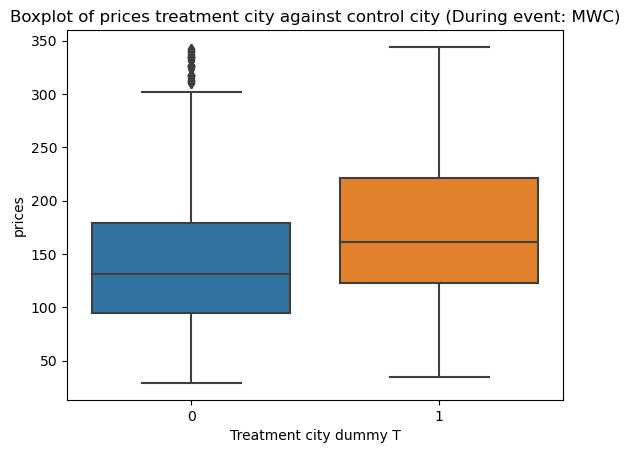

In [14]:
barcelona_city = pd.concat([df1_common[df1_common['City']=='Barcelona'], df1_common[df1_common['City']==city_control]], ignore_index=True)

# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_city , x='T', y='Price')
plt.title('Boxplot of prices treatment city against control city (During event: MWC)')
plt.xlabel('Treatment city dummy T')
plt.ylabel('prices')
plt.show()

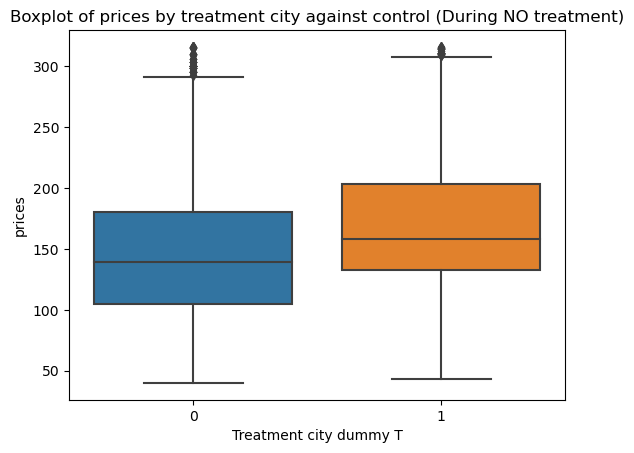

In [15]:
barcelona_cityNT = pd.concat([df2_common[df2_common['City']=='Barcelona'], df2_common[df2_common['City']==city_control]], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_cityNT , x='T', y='Price')
plt.title('Boxplot of prices by treatment city against control (During NO treatment)')
plt.xlabel('Treatment city dummy T')
plt.ylabel('prices')
plt.show()

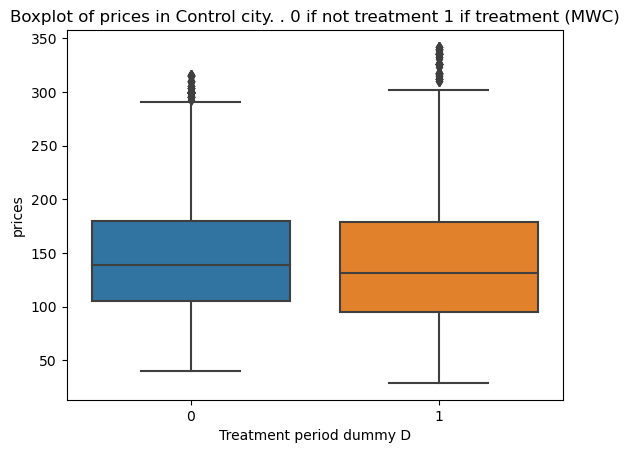

In [16]:
city = pd.concat([df1_common[df1_common['City']==city_control], df2_common[df2_common['City']==city_control]], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=city , x='D', y='Price')
plt.title('Boxplot of prices in Control city. . 0 if not treatment 1 if treatment (MWC)')
plt.xlabel('Treatment period dummy D')
plt.ylabel('prices')
plt.show()

In [17]:
#Creation of the big data frame
combined_df = pd.concat([df1_common,df2_common], ignore_index=True)
combined_df['T*D'] = combined_df['T'] * combined_df['D']
# Display the combined DataFrame
print(combined_df.shape)
combined_df.head()

(38819, 12)


,City,Start_Date,End_Date,Hotel_Name,Price,Hotel_Description_Short,Rating,url,Hotel_Description_Long,D,T,T*D
0,Barcelona,2024-02-23,2024-02-24,Room Mate Gerard,224.0,NaN,8.8,https://www.booking.com/hotel/es/room-mate-ger...,Room Mate Gerard in Barcelona provides accommo...,1,1,1
1,Barcelona,2024-02-23,2024-02-24,Sonder Los Arcos,271.0,NaN,8.4,https://www.booking.com/hotel/es/sonder-los-ar...,Sonder Los Arcos features accommodation with f...,1,1,1
2,Barcelona,2024-02-23,2024-02-24,Citadines Ramblas Barcelona,116.0,NaN,8.5,https://www.booking.com/hotel/es/citadines.en-...,Centrally located on Barcelona’s famous Las Ra...,1,1,1
3,Barcelona,2024-02-23,2024-02-24,Hotel Derby,101.0,NaN,8.3,https://www.booking.com/hotel/es/derby.en-gb.h...,Situated 300 metres from L’Illa Diagonal Shopp...,1,1,1
4,Barcelona,2024-02-23,2024-02-24,Hotel Concordia Barcelona,105.0,NaN,8.1,https://www.booking.com/hotel/es/concordia.en-...,Hotel Concordia Barcelona is situated 800 metr...,1,1,1


In [18]:
combined_df.describe() #Checked if it worked 

,Price,Rating,D,T,T*D
count,38819.000000,35733.000000,38819.00000,38819.000000,38819.000000
mean,135.001211,8.183214,0.47196,0.269224,0.115253
std,61.368259,1.081067,0.49922,0.443562,0.319331
min,25.000000,1.000000,0.00000,0.000000,0.000000
25%,89.000000,7.800000,0.00000,0.000000,0.000000
50%,123.000000,8.400000,0.00000,0.000000,0.000000
75%,168.000000,8.900000,1.00000,1.000000,0.000000
max,344.000000,10.000000,1.00000,1.000000,1.000000


In [19]:
#Checking before running the regressions
mean_prices = combined_df.groupby(['T', 'D']).mean()
mean_prices_table = mean_prices.reset_index()
print(mean_prices_table)

   T  D       Price    Rating  T*D
0  0  0  125.158873  8.204413  0.0
1  0  1  116.617534  8.195761  0.0
2  1  0  168.906140  8.170520  0.0
3  1  1  178.548279  8.099652  1.0


C:\Users\School\AppData\Local\Temp\ipykernel_14500\2948570360.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_prices = combined_df.groupby(['T', 'D']).mean()


In [20]:
# Regression 1: Treatment Period Dummy Only (T)
model1 = sm.OLS(combined_df['Price'], sm.add_constant(combined_df['D'])).fit()
results_summary1 = model1.params
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     98.16
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           4.10e-23
Time:                        14:41:43   Log-Likelihood:            -2.1485e+05
No. Observations:               38819   AIC:                         4.297e+05
Df Residuals:                   38817   BIC:                         4.297e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        137.9151      0.428    322.156      0.0

In [21]:
# Regression 2: Treatment City Dummy Only (D)
model2 = sm.OLS(combined_df['Price'], sm.add_constant(combined_df['T'])).fit()
results_summary2 = model2.params
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     6398.
Date:                Sat, 03 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:41:43   Log-Likelihood:            -2.1193e+05
No. Observations:               38819   AIC:                         4.239e+05
Df Residuals:                   38817   BIC:                         4.239e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        120.9897      0.338    358.380      0.0

In [22]:
# Regression 3: Both Treatment Period and City Dummy with Interaction (DiD)
all = ['D', 'T', 'T*D'] 
model3 = sm.OLS(combined_df['Price'], sm.add_constant(combined_df[all])).fit()
results_summary3 = model3.params
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     2224.
Date:                Sat, 03 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:41:43   Log-Likelihood:            -2.1182e+05
No. Observations:               38819   AIC:                         4.236e+05
Df Residuals:                   38815   BIC:                         4.237e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.1589      0.470    266.036      0.0

In [23]:
# Convert to DataFrames
df1 = pd.DataFrame(results_summary1, index=['const', 'D'])
df2 = pd.DataFrame(results_summary2, index=['const', 'T'])
df3 = pd.DataFrame(results_summary3, index=['const', 'D', 'T', 'T*D'])

# Concatenate the DataFrames side by side
combined_results = pd.concat([df1, df2, df3], axis=1, keys=['Model 1', 'Model 2', 'Model 3'])

# Display the combined table
print(combined_results)

          Model 1     Model 2     Model 3
                0           0           0
const  137.915114  120.989671  125.158873
D       -6.174052         NaN   -8.541339
T             NaN   52.044201   43.747267
T*D           NaN         NaN   18.183478


**Model 1: Treatment period**

$\beta_0$: The average price when the treatment is not in effect is 1478.32. This serves as the baseline price in periods without the treatment.

$\beta_1$: The coefficient of 749.10 for the treatment period dummy indicates that, during the treatment period, prices were on average 654.99 units higher than in periods without the treatment. This captures the average effect of the treatment over time, but without distinguishing between cities.

**Model 2: Treatment city:**

$\beta_0$: The average price in the control city is 1079.69, this could be interpretated as the baseline.

$\beta_2$: The coefficient of 1545.59 for the treatment city dummy suggests that, on average, prices in the treatment city are 1545.59 units higher than in the control city. This captures the average difference in prices between the treatment city and the control city, without accounting for time variation.

**Model 3: Both Treatment Period and City Dummy with Interaction (DiD)**

$\beta_0$: The baseline price, which is 1085.59, represents the average price in control cities outside the treatment period.

$\beta_1$: The coefficient -11.80 suggests that, holding city type constant, the treatment period alone does not significantly affect the price or might slightly reduce it, which contrasts with Model 1 because it now controls for city type. We must highlight that this coefficient is not statistically significant. 

$\beta_2$: The coefficient 785.06 indicates that, controlling for the period, the treatment city has prices that are on average 785.06 units higher than in control cities. This is a different aspect of the treatment effect, showing the city's baseline difference.

$\alpha$: The interaction term coefficient of 1521.05 is the most crucial part of the DiD analysis. It measures the differential effect of being in the treatment city during the treatment period compared to control cities and periods. This coefficient suggests that the treatment had a positive effect on prices, increasing them by 1318.41 units more than the combined individual effects of being in the treatment period and city.

The negative coefficient for D indicates a general decline in the outcome variable during the treatment period, but this does not mean the treatment was ineffective. The positive T*D interaction term in Models 3 and 4 suggests that the treatment had a positive effect when correctly comparing the treatment and control groups over time.
The effectiveness of the treatment is gauged by the T*D coefficient, not just the D coefficient. The D coefficient alone cannot tell you about the effectiveness of the treatment; it only indicates the overall trend during the treatment period across both groups.

**Overall**

 The results suggest that, while the treatment period and being in the treatment city individually have discernible effects on prices, the combined effect of being in the treatment city during the treatment period (captured by the interaction term in Model 3) is substantial and positive. This is indicative of the treatment's effectiveness. The negative coefficient for $D$ in Model 3, in contrast to its positive coefficient in Model 1, suggests that once you account for the difference between cities, the treatment period's standalone effect might be negative or negligible (which is the case since the coefficient is not statitically significant). This emphasizes the importance of the interaction term in capturing the true effect of the treatment. It's important to note that $\alpha$ (the coefficient for the interaction term $T*D$) is what truly captures the DiD estimate, indicating the incremental effect of the treatment over and above the individual effects of being in the treatment city or period.


# Part 3: Description NLP

Basic EDA of the prices contained in the dataset

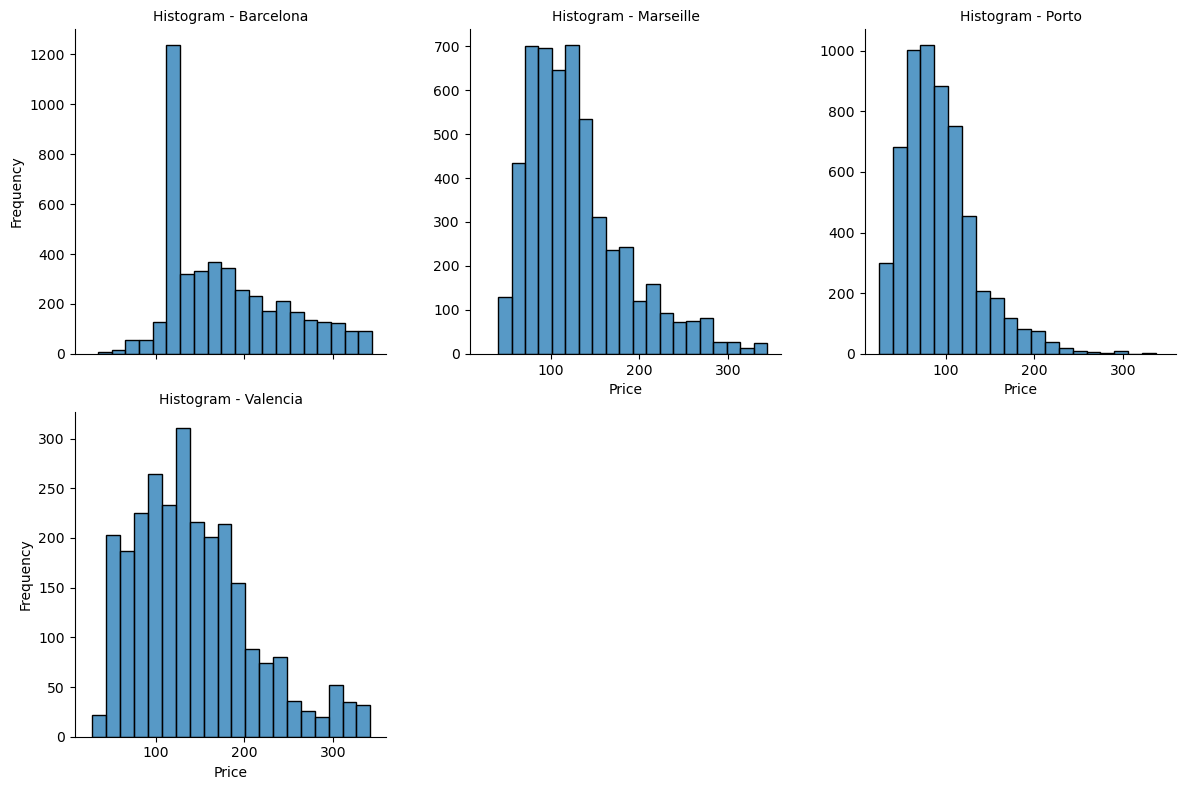

In [24]:
# Histogram of prices for each unique City in a grid
grid = sns.FacetGrid(df1_common, col='City', col_wrap=3, height=4, sharey=False)
grid.map(sns.histplot, 'Price', kde=False, bins=20)
grid.set_titles('Histogram - {col_name}')
grid.set_axis_labels('Price', 'Frequency')
plt.show()



Line Event from:  2024-02-23  to:  2024-03-03
Line no-Event from:  2024-03-08  to:  2024-03-17


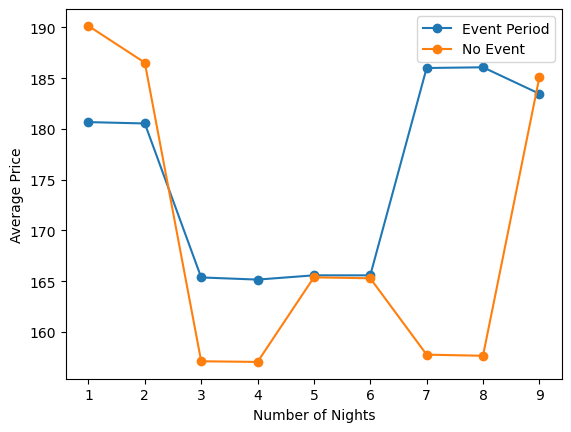

In [25]:
df1 = df1_common[df1_common['City']=='Barcelona'].copy()
df2 = df2_common[df2_common['City']=='Barcelona'].copy()
print("Line Event from: ",df1['Start_Date'].min(), " to: ", df1['End_Date'].max())
print("Line no-Event from: ",df2['Start_Date'].min(), " to: ", df2['End_Date'].max())

# Assuming 'Start_Date' is in string format, convert it to datetime
df1['Start_Date'] = pd.to_datetime(df1['Start_Date'])
df2['Start_Date'] = pd.to_datetime(df2['Start_Date'])

# Calculate the number of nights for each dataset
df1['Nights'] = (df1['Start_Date'] - df1['Start_Date'].min()).dt.days + 1
df2['Nights'] = (df2['Start_Date'] - df2['Start_Date'].min()).dt.days + 1

# Continue with the rest of your code
avg_price1 = df1.groupby('Nights')['Price'].mean()
avg_price2 = df2.groupby('Nights')['Price'].mean()

# Create the plot
plt.plot(avg_price1.index, avg_price1, label='Event Period', marker='o')
plt.plot(avg_price2.index, avg_price2, label='No Event', marker='o')

# Add labels and legend
plt.xlabel('Number of Nights')
plt.ylabel('Average Price')
plt.legend()

# Show the plot
plt.show()

TODO: Explain graph

In [26]:
def get_size_of_common_hotel_per_night(df1, df2):
    # Group the dataframes by 'Start_Date' and count the number of common hotels for each date
    grouped_df1 = df1.groupby('Start_Date')['Hotel_Name'].apply(set)
    grouped_df2 = df2.groupby('Start_Date')['Hotel_Name'].apply(set)

    # Find the intersection of hotel names across all dates
    common_hotels1 = set.intersection(*grouped_df1)
    common_hotels2 = set.intersection(*grouped_df2)

    # Filter the original dataframe to keep only the common hotels
    result_df1 = df1[df1['Hotel_Name'].isin(common_hotels1)]
    result_df2 = df2[df2['Hotel_Name'].isin(common_hotels2)]
    print("Common hotels: ", len(common_hotels1),", ", len(common_hotels2))
    return result_df1, result_df2

df1_c, df2_c = get_size_of_common_hotel_per_night(df1_common, df2_common)


Common hotels:  970 ,  853


In [27]:
# Prices in the event week
df1_group = df1_common.groupby('Start_Date').agg({'Price': 'mean', 'Rating': 'mean'}).reset_index()
df1_group

,Start_Date,Price,Rating
0,2024-02-23,137.190043,8.190867
1,2024-02-24,137.111908,8.190405
2,2024-02-25,121.107644,8.151336
3,2024-02-26,120.886056,8.152587
4,2024-02-27,122.120736,8.133094
5,2024-02-28,121.950108,8.133533
6,2024-02-29,136.707830,8.207336
7,2024-03-01,136.677723,8.206283
8,2024-03-02,146.891538,8.156352


In [28]:
# Prices in the non-event week
df2_group = df2_common.groupby('Start_Date').agg({'Price': 'mean', 'Rating': 'mean'}).reset_index()
df2_group

,Start_Date,Price,Rating
0,2024-03-08,149.461217,8.159606
1,2024-03-09,146.622273,8.190559
2,2024-03-10,131.702941,8.194465
3,2024-03-11,131.537783,8.194968
4,2024-03-12,134.407423,8.215160
5,2024-03-13,134.178750,8.209442
6,2024-03-14,135.135399,8.200137
7,2024-03-15,135.284805,8.204292
8,2024-03-16,146.503470,8.166371


Tokenize the descriptions: use the Description_Analysis() to tokenize and preprocess the hotel descriptions. The results of this process won't be used, hence only a sample of the descriptions are being preprocess to reduce running time. 

In [29]:
tqdm.pandas()

df_copy_token = df1_common.copy()
# Keep only sample of the dataset
df_copy_token = df_copy_token.sample(frac=0.1, random_state=1)
df_copy_token = df_copy_token.dropna(subset=['Hotel_Description_Long'])

# Tokenize the descriptions
des_analysis = da.Description_Analysis()
text_preprocessing = (
    df_copy_token['Hotel_Description_Long']
    .dropna()
    .astype(str)
    .progress_apply(lambda x: des_analysis.tokenize(x,1))
)

df_copy_token['Tokenized_Description'] = text_preprocessing

# Create a list of unique tokens
vocab, token_count = {}, 1
for doc in df_copy_token['Tokenized_Description']:
    tokens = doc.split()
    for token in tokens:
        if token not in vocab:
            vocab[token] = token_count
            token_count += 1

# Create a DataFrame
vec = []
for doc in df_copy_token['Tokenized_Description']:
    vec.append(des_analysis.vectorize(doc, vocab))
df_tokens1 = pd.DataFrame(vec)
df_tokens1.columns = vocab.keys()
print(df_tokens1.shape)
df_tokens1.head()

 48%|████▊     | 886/1831 [00:01<00:01, 578.80it/s]

100%|██████████| 1831/1831 [00:03<00:00, 573.85it/s]


Use Description_Analysis.py to find the words having the highest coefficients and R-squared  in OLS regression for 1-ngram (max_features=5000):

In [ ]:
des_analysis = da.Description_Analysis()
best_coefs, summary = des_analysis.get_best_coefficients(df1_common, TFidf=False, n_gram_min = 1, n_gram_max = 1)

Number of common words: 5000
Top 1 word based on coefficient: m² (110.05031730946585)
Top 2 word based on coefficient: mat (102.04639309584141)
Top 3 word based on coefficient: clients (100.17159418512288)
Top 1 word based on R-squared: barcelona (0.11251706454429877)
Top 2 word based on R-squared: sá (0.07326506635173369)
Top 3 word based on R-squared: carneiro (0.07224481474192201)



In [ ]:
best_coefs, summary = des_analysis.get_best_coefficients(df1_common, TFidf=False, n_gram_min = 2, n_gram_max = 2)

Number of common words: 5000
Top 1 word based on coefficient: off barcelona (74.39977012390102)
Top 2 word based on coefficient: catalan german (72.22357024258575)
Top 3 word based on coefficient: have simple (69.51677674018285)
Top 1 word based on R-squared: sá carneiro (0.07392708235071299)
Top 2 word based on R-squared: francisco sá (0.07219765607693007)
Top 3 word based on R-squared: is francisco (0.06069188981919793)



### OLS regression on selected features:

Utilize the `get_selected_features()` method from Description_Analysis.py to obtain summary statistics of an OLS regression using the specified features as controls. If any of the selected features are not present in the corpus, an error message will be displayed. The function parameters include:
- df: DataFrame, the dataset containing the descriptions.
- selected_features: a list containing strings, with a maximum 3 different 3-grams.
- (optional) TfiDf = True: Use TFiDF for vectorization; otherwise, CountVectorize will be employed.

In [ ]:
# SELECTED Features (1-gram)
selected_features = ['Wifi','Pool']
model_selected, matrix = des_analysis.get_selected_features(df1_common, selected_features)
print(model_selected.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     175.7
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           3.34e-76
Time:                        14:32:44   Log-Likelihood:                -90794.
No. Observations:               16317   AIC:                         1.816e+05
Df Residuals:                   16314   BIC:                         1.816e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.0663      0.931    150.523      0.0

In [ ]:
# Selected Features (2-gram)
selected_features_2 = ['Free Wifi','Friendly staff']
model_selected_2, matrix_2 = des_analysis.get_selected_features(df1_common, selected_features_2)
print(model_selected_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     321.4
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           3.50e-71
Time:                        14:33:01   Log-Likelihood:                -90808.
No. Observations:               16317   AIC:                         1.816e+05
Df Residuals:                   16315   BIC:                         1.816e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.0297      0.920    156.581      0.0

This method from Description_Analysis return a SentimentIntensityAnalyzer which is part of the Natural Language Toolkit (NLTK) library and is commonly used to analyze the sentiment of a piece of text. It provides a compound score that represents the overall sentiment of the text, ranging from -1 (most negative) to 1 (most positive).

The results are printed for each city.

In [ ]:
# Get sentiment alalysis
sentiment = des_analysis.get_sentiment(df1_common,df2_common)
print(sentiment)

c:\Users\School\Documents\DSDM_2023-2024\Period_2\I_NLP\Assignment_1\Booking-Scraping\src\description_analysis.py:264: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sentiments = pd.Series(index=copy_df1.index)


        City Sentiment          
                  mean       std
0  Barcelona  0.821999  0.184146
1  Marseille  0.762452  0.210307
2      Porto  0.811630  0.181484
3   Valencia  0.746578  0.214103
None


### 4th Regression:

In [ ]:
# merge combined_df with result of matrix 
combined_df = pd.concat([combined_df, matrix], axis=1)
print(combined_df.shape)

(38819, 5012)


In [ ]:
# Regression 4: All features
all = ['D', 'T', 'T*D'] + model_selected.params.index.tolist()
all.remove('const')
combined_df = combined_df.fillna(0)
model4 = sm.OLS(combined_df['Price'], sm.add_constant(combined_df[all])).fit()
results_summary4 = model4.params
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     1356.
Date:                Sat, 03 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:39:10   Log-Likelihood:            -2.1177e+05
No. Observations:               38819   AIC:                         4.236e+05
Df Residuals:                   38813   BIC:                         4.236e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.1589      0.470    266.348      0.0

In [ ]:
# Convert to DataFrames
df1 = pd.DataFrame(results_summary1, index=['const', 'D'])
df2 = pd.DataFrame(results_summary2, index=['const', 'T'])
df3 = pd.DataFrame(results_summary3, index=['const', 'D', 'T', 'T*D'])
df4 = pd.DataFrame(model4.params)

# Concatenate the DataFrames side by side
combined_results = pd.concat([df1, df2, df3, df4], axis=1, keys=['Model 1', 'Model 2', 'Model 3', 'Model 4'])

# Display the combined table
print(combined_results)

          Model 1     Model 2     Model 3     Model 4
                0           0           0           0
const  137.915114  120.989671  125.158873  125.158873
D       -6.174052         NaN   -8.541339  -12.316844
T             NaN   52.044201   43.747267   43.747267
T*D           NaN         NaN   18.183478   17.730666
wifi          NaN         NaN         NaN    3.464463
pool          NaN         NaN         NaN    8.036726
